In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

COLUMNS = ['Date','Total_Cases','New_Daily_Cases','New_Daily_Deaths','Total_Deaths','Total_Recoveries']

In [57]:
import requests
import sys
import csv
import datetime

def generate_csv(code):
    url = "https://thevirustracker.com/free-api?countryTimeline=" + code

    r = requests.get(url, headers={"User-Agent": "XY"})

    data = r.json()
    keys = data['timelineitems'][0].keys()
    length = len(keys)
    name = "covid" + code + ".csv"
    with open(name, 'w', newline='') as file:
                writer = csv.writer(file)
                for key in keys:
                    if length > 2:
                        row = []
                        x = datetime.datetime.strptime(key, '%m/%d/%Y')
                        xn = x - datetime.timedelta(days=1)
                        date = xn.strftime("%m/%d/%Y")
                        row.append(date)
                        row.append(data['timelineitems'][0][key]['total_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_deaths'])
                        row.append(data['timelineitems'][0][key]['total_deaths'])
                        row.append(data['timelineitems'][0][key]['total_recoveries'])
                        writer.writerow(row)
                        length-=1

In [8]:
def create_dataset(siglas):
    result = pd.DataFrame()
    for i in siglas:
        t = generate_csv(i)
        t_d = pd.read_csv('covid'+i+'.csv')
        tmp = [j+i for j in COLUMNS[1:]]
        tmp.insert(0,'Date')
        t_d.columns = tmp
        t_d.set_index('Date', inplace=True, drop=True)
        result = pd.concat([result,t_d], axis=1, sort=True)    

In [63]:
generate_csv("PT")
generate_csv("IT")
generate_csv("ES")

In [2]:
dataPT = pd.read_csv('covidPT.csv')
tmp = [i+"PT" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataPT.columns = tmp
dataPT.set_index('Date', inplace=True, drop=True)
dataPT.head()

,Total_CasesPT,New_Daily_CasesPT,New_Daily_DeathsPT,Total_DeathsPT,Total_RecoveriesPT
Date,,,,,
03/01/2020,2,2,0,0,0
03/02/2020,2,0,0,0,0
03/03/2020,5,3,0,0,0
03/04/2020,9,4,0,0,0
03/05/2020,13,4,0,0,0


In [4]:
dataES = pd.read_csv('covidES.csv')
tmp = [i+"ES" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataES.columns = tmp
dataES.set_index('Date', inplace=True, drop=True)

dataIT = pd.read_csv('covidIT.csv')
tmp = [i+"IT" for i in COLUMNS[1:]]
tmp.insert(0,'Date')
dataIT.columns = tmp
dataIT.set_index('Date', inplace=True, drop=True)
edataIT.head()

,Total_CasesIT,New_Daily_CasesIT,New_Daily_DeathsIT,Total_DeathsIT,Total_RecoveriesIT
Date,,,,,
01/30/2020,2,2,0,0,0
01/31/2020,2,0,0,0,0
02/01/2020,2,0,0,0,0
02/02/2020,2,0,0,0,0
02/03/2020,2,0,0,0,0


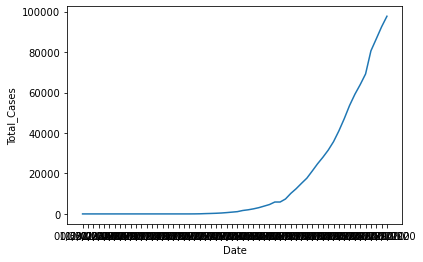

In [7]:
# Visualization
X = dataPT.drop(columns=['New_Daily_Deaths','Date'], axis=0)
y = dataPT['New_Daily_Deaths']

time = dataIT.drop(columns=['New_Daily_Deaths','New_Daily_Cases','Total_Deaths','Total_Recoveries'], axis=0)
time.head()
sb.lineplot('Date','Total_Cases',data=time)

In [32]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [29]:
def prepare_dataset(dataset, timesteps=5, multisteps=1):
    data = dataset.values
    X=[]
    y=[]
    for i in range(dataset.shape[0] - (timesteps + multisteps)):
        input_index = i + timesteps
        label_index = input_index + multisteps
        X.append(data[i:input_index,:])
        y.append(data[input_index:label_index,0])
    return X,y

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Prepare data from LSTM
data_lstm = dataIT.drop(columns=['New_Daily_CasesIT','New_Daily_DeathsIT','Total_DeathsIT','Total_RecoveriesIT'], axis=0)
#data_lstm['Date'] = range(0,len(dataIT_dates))
#print(data_lstm.head)

scaler = MinMaxScaler((-1,1))
data_lstm['Total_CasesIT'] = scaler.fit_transform(np.array(data_lstm['Total_CasesIT']).reshape(-1,1))
#print(data_lstm)
X, y = prepare_dataset(data_lstm)

X_reshaped = np.array(X).reshape((52,5,1))
print(X_reshaped)

[[[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-0.99997953]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-0.99997953]
  [-0.99997953]]

 [[-1.        ]
  [-1.        ]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-1.        ]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]
  [-0.99997953]]

 [[-0.99997953]


In [47]:
train_size = int(len(X_reshaped) * 0.66)
train_x, test_x = X_reshaped[0:train_size], X_reshaped[train_size:len(X_reshaped)]
train_y, test_y = y[0:train_size], y[train_size:len(y)]

In [50]:
# LSTM
from tensorflow.keras import Sequential, layers, optimizers, losses

TIMESTAMPS = 5
FEATURES   = 1
BATCH_SIZE = 52


model = Sequential()
model.add(layers.LSTM(8,stateful=True,
                      batch_input_shape=(BATCH_SIZE,TIMESTAMPS,FEATURES)))
model.add(layers.Dense(FEATURES,activation='relu'))

model.compile(
    loss="mean_squared_error",
    optimizer= optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
for i in range(100):
    model.fit(train_x,train_y, shuffle=False, batch_size=BATCH_SIZE, epochs=1, verbose=2)
    model.reset_states()

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), for inputs ['dense_1'] but instead got the following list of 34 arrays: [array([[-1.]]), array([[-1.]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]), array([[-0.99997953]]),...

In [ ]:
for i in range(len(test)):
        # make one-step forecast
        Xx, yy = test[i, 0:-1], test[i, -1]
        yhat = model.predict(X, batch_size=BATCH_SIZE)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

In [68]:
# Linear Regression



from sklearn.linear_model import LinearRegression
model_death = LinearRegression()
model_death.fit(X,y)
new_y = model.predict()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)